# 训练深层神经网络

1. 梯度消失
2. 训练缓慢
3. 过拟合

### 在梯度消失的问题上：我们需要每层输出的方差等于其输入的方差。
### 1. 使用参数初始化技巧

![参数初始化](./images/参数初始化.PNG)

In [2]:
import tensorflow as tf

>he_init = _tf.contrib.layers.variance_scaling_initializer()

>hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu,kernel_initializer=he_init, name="hidden1")


### 2. 选取非饱和激活函数 

$ LeakyReLU \alpha(z) = max(az\cdot z)$

通常设置a = 0.01  but有时候a=0.2似乎比较好

## 选取指数线性单元ELU

In [9]:
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

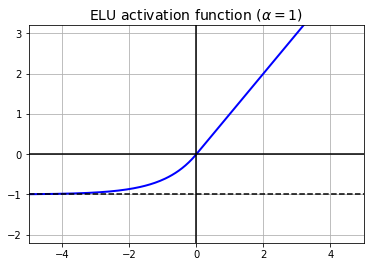

In [12]:
z = np.linspace(-5, 5, 200)

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("elu_plot")
plt.show()

## 选取缩放型指数线性单元SELU

In [13]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

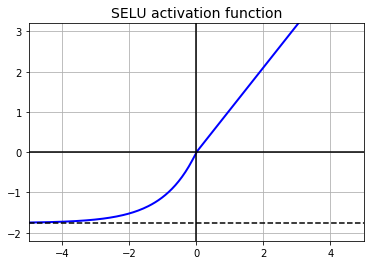

In [14]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

#save_fig("selu_plot")
plt.show()

In [19]:
import tensorflow as tf
n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

tf.reset_default_graph()

X = tf.placeholder(tf.float32,shape=(None,n_inputs),name="X")
y= tf.placeholder(tf.int64,shape=(None),name="y")

def neuron_layer(X,n_neuron,name,activation=None):
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2/np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs,n_neuron),stddev=stddev)
        w = tf.Variable(init,name="wegihts")
        b = tf.Variable(tf.zeros([n_neuron]),name="biases")
        z = tf.matmul(X,w)+b
        if activation == "relu":
            return tf.nn.relu(z)
        else:
            return z

from datetime import datetime
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(X,n_hidden1,"hidden1",activation="relu")
    hidden2 = neuron_layer(hidden1,n_hidden2,"hidden2",activation="relu")
    logits = neuron_layer(hidden2,n_outputs,"output")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,logits=logits)
    loss = tf.reduce_mean(xentropy,name="loss")



learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

accuracy_summary = tf.summary.scalar('accuracy', accuracy)
loss_summary = tf.summary.scalar('loss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

# 执行阶段

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

n_epochs = 40
batch_size = 50
n_batches = len(X_train)//batch_size

def shuffle_data(X,y,epoch,batch_size,batch_index):
    np.random.seed(epoch*n_batches + batch_index)
    random_index = np.random.randint(len(X_train),size=batch_size)
    X_batch = X[random_index]
    y_batch = y[random_index]
    return X_batch,y_batch

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch,y_batch = shuffle_data(X_train,y_train,epoch,batch_size,batch_index)
            sess.run(training_op,feed_dict={X:X_batch,y:y_batch})
            if batch_index % 10 == 0:
                summary_str = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
        summary_str = accuracy_summary.eval(feed_dict={X: X_batch, y: y_batch})
        step = epoch
        file_writer.add_summary(summary_str, step)
        acc_train = accuracy.eval(feed_dict={X:X_batch,y:y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test,y:y_test})
        file_writer.add_summary(accuracy_summary.eval(feed_dict={X: X_test,y:y_test}), step)
        print(epoch, "Train accuracy:", acc_train, "Test accuracy:", acc_test)
    save_path = saver.save(sess, "./tmp/my_model_final.ckpt")
file_writer.close()

with tf.Session() as sess:
    saver.restore(sess, "./tmp/my_model_final.ckpt") # or better, use save_path
    X_new_scaled = X_test[:20]
    Z = logits.eval(feed_dict={X: X_new_scaled})
    y_pred = np.argmax(Z, axis=1)                 

print("Predicted classes:", y_pred)
print("Actual classes:   ", y_test[:20])

0 Train accuracy: 0.9 Test accuracy: 0.9108
1 Train accuracy: 0.92 Test accuracy: 0.9298
2 Train accuracy: 0.98 Test accuracy: 0.9384
3 Train accuracy: 0.94 Test accuracy: 0.9487
4 Train accuracy: 1.0 Test accuracy: 0.9496
5 Train accuracy: 0.98 Test accuracy: 0.9553
6 Train accuracy: 1.0 Test accuracy: 0.9564
7 Train accuracy: 0.96 Test accuracy: 0.9603
8 Train accuracy: 0.92 Test accuracy: 0.9614
9 Train accuracy: 0.98 Test accuracy: 0.9637
10 Train accuracy: 0.98 Test accuracy: 0.9642
11 Train accuracy: 0.98 Test accuracy: 0.9665
12 Train accuracy: 0.98 Test accuracy: 0.9645
13 Train accuracy: 0.98 Test accuracy: 0.967
14 Train accuracy: 0.96 Test accuracy: 0.9685
15 Train accuracy: 1.0 Test accuracy: 0.9695
16 Train accuracy: 0.98 Test accuracy: 0.9704
17 Train accuracy: 1.0 Test accuracy: 0.9721
18 Train accuracy: 1.0 Test accuracy: 0.9714
19 Train accuracy: 1.0 Test accuracy: 0.9718
20 Train accuracy: 0.98 Test accuracy: 0.9723
21 Train accuracy: 0.98 Test accuracy: 0.9732
22 Tra

# 批量标准化